<a href="https://colab.research.google.com/github/gabbosanti/machine-learning-assignment/blob/main/assignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CRISP-DM Based Analysis of Second-Half Goal Scoring in Football

This notebook contains all the code of the assignement. The workflow follows the CRISP-DM pattern.

# Business Understanding

# Data Understanding

For the analysis in our system, many free available datasets are available.
Kaggle is one of the most famous online platforms that contains lot of free available dataset.

This dataset is one of the most complete and general-purpouse dataset available, and it's actually composed of :

*   events.csv
*   ginf.csv
*   dictionary.txt

Considering the huge number of events, it's a good idea to store them



In [1]:
import kagglehub
import os, shutil
from pathlib import Path

path = kagglehub.dataset_download("secareanualin/football-events")
print("Kaggle dataset path:", path)

work_dir = Path("data")
work_dir.mkdir(exist_ok=True)

for fname in ["events.csv", "ginf.csv", "dictionary.txt"]:
    shutil.copy(Path(path) / fname, work_dir / fname)

events_path = work_dir / "events.csv"
ginf_path   = work_dir / "ginf.csv"


100%|██████████| 21.1M/21.1M [00:00<00:00, 120MB/s]

Extracting files...


Kaggle dataset path: /root/.cache/kagglehub/datasets/secareanualin/football-events/versions/1


Stores the datasets in a Pandas dataframe.

In [2]:
import pandas as pd

events_df = pd.read_csv(events_path)
ginf_df   = pd.read_csv(ginf_path)


### Data Profiling

Once we collect our data, it's important to describe their statistics

In [3]:
events_summary = pd.DataFrame({
    "dtype": events_df.dtypes,
    "non_null_count": events_df.notna().sum(),
    "null_count": events_df.isna().sum(),
    "unique_values": events_df.nunique()
})

events_summary


,dtype,non_null_count,null_count,unique_values
id_odsp,object,941009,0,9074
id_event,object,941009,0,941009
sort_order,int64,941009,0,180
time,int64,941009,0,101
text,object,941009,0,366076
event_type,int64,941009,0,11
event_type2,float64,214293,726716,4
side,int64,941009,0,2
event_team,object,941009,0,142
opponent,object,941009,0,142


In [4]:
ginf_df_summary = pd.DataFrame({
    "dtype": ginf_df.dtypes,
    "non_null_count": ginf_df.notna().sum(),
    "null_count": ginf_df.isna().sum(),
    "unique_values": ginf_df.nunique()
})

ginf_df_summary

,dtype,non_null_count,null_count,unique_values
id_odsp,object,10112,0,10112
link_odsp,object,10112,0,10112
adv_stats,bool,10112,0,2
date,object,10112,0,967
league,object,10112,0,5
season,int64,10112,0,6
country,object,10112,0,5
ht,object,10112,0,147
at,object,10112,0,148
fthg,int64,10112,0,11


# Data Preparation



In [5]:
def create_dataset():

    # Reduce events_df dataset, filtering only first-half events
    first_half_events = events_df[events_df['time'] <= 45].copy()

    #Discarding useless features
    first_half_events = first_half_events.drop(columns=['sort_order' , 'time', 'text' , 'event_team' , 'opponent', 'player' , 'player2' , 'player_in' , 'player_out' , 'shot_place', 'location' , 'bodypart' , 'assist_method' , 'situation', 'fast_break'])

    #Extracting only matches with events
    matches_with_events = first_half_events['id_odsp'].unique()
    ginf_filtered = ginf_df[ginf_df['id_odsp'].isin(matches_with_events)].copy()

    # Creating new features
    first_half_events['shot_on_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 1)
    ).astype(int)

    first_half_events['shot_off_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 2)
    ).astype(int)

    first_half_events['corner'] = (first_half_events['event_type'] == 2).astype(int)
    first_half_events['free_kick'] = (first_half_events['event_type'] == 8).astype(int)
    first_half_events['offside'] = (first_half_events['event_type'] == 9).astype(int)
    first_half_events['foul'] = (first_half_events['event_type'] == 3).astype(int)
    first_half_events['yellow_card'] = (first_half_events['event_type'] == 4).astype(int)
    first_half_events['goal'] = first_half_events['is_goal'].astype(int)

    # Aggregation : calculating how many occurences of every event
    matches_features = (first_half_events.groupby(['id_odsp', 'side'] , as_index=False).agg({
            'shot_on_target': 'sum',
            'shot_off_target': 'sum',
            'corner': 'sum',
            'free_kick': 'sum',
            'offside': 'sum',
            'foul': 'sum',
            'yellow_card': 'sum',
            'goal': 'sum'
        })
    )

    #Split between home and away
    home = matches_features[matches_features['side'] == 1].drop(columns='side').add_suffix('_home')
    away = matches_features[matches_features['side'] == 2].drop(columns='side').add_suffix('_away')

    #Renaming columns for merging
    home = home.rename(columns={'id_odsp_home': 'id_odsp'})
    away = away.rename(columns={'id_odsp_away': 'id_odsp'})

    #Merging to ginf_ds
    dataset = (
        ginf_filtered[['id_odsp', 'fthg']]
        .merge(home, on='id_odsp', how='left')
        .merge(away, on='id_odsp', how='left')
    )

    dataset['home_scored_second_half'] = (
        (dataset['fthg'] - dataset['goal_home']) > 0
    ).astype(int)

    dataset = dataset.drop(columns=['fthg'])
    return pd.DataFrame(dataset)


In [6]:
df = create_dataset()
df

,id_odsp,shot_on_target_home,shot_off_target_home,corner_home,free_kick_home,offside_home,foul_home,yellow_card_home,goal_home,shot_on_target_away,shot_off_target_away,corner_away,free_kick_away,offside_away,foul_away,yellow_card_away,goal_away,home_scored_second_half
0,UFot0hit/,3,5,4,5,1,5,0,2,0,2,2,5,0,6,1,0,1
1,Aw5DflLH/,3,3,2,15,0,8,2,0,1,1,2,9,0,15,1,0,1
2,bkjpaC6n/,2,2,2,15,3,5,0,0,1,0,2,7,4,15,1,0,1
3,CzPV312a/,0,3,2,5,3,10,1,0,2,1,2,11,4,4,1,1,0
4,GUOdmtII/,1,5,1,6,1,6,0,1,4,3,5,6,1,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,xAkY8l6R/,1,0,2,3,3,9,0,1,2,2,5,9,1,3,1,0,1
9070,xSU9scI9/,2,1,7,7,1,6,1,1,2,1,2,6,0,7,2,0,1
9071,xY7uZwOI/,6,5,3,7,2,4,0,3,0,0,1,4,0,7,1,0,1
9072,YyeGxMX8/,3,4,6,6,4,4,0,0,1,2,4,4,1,5,1,0,0


Now that we have our full-dataset

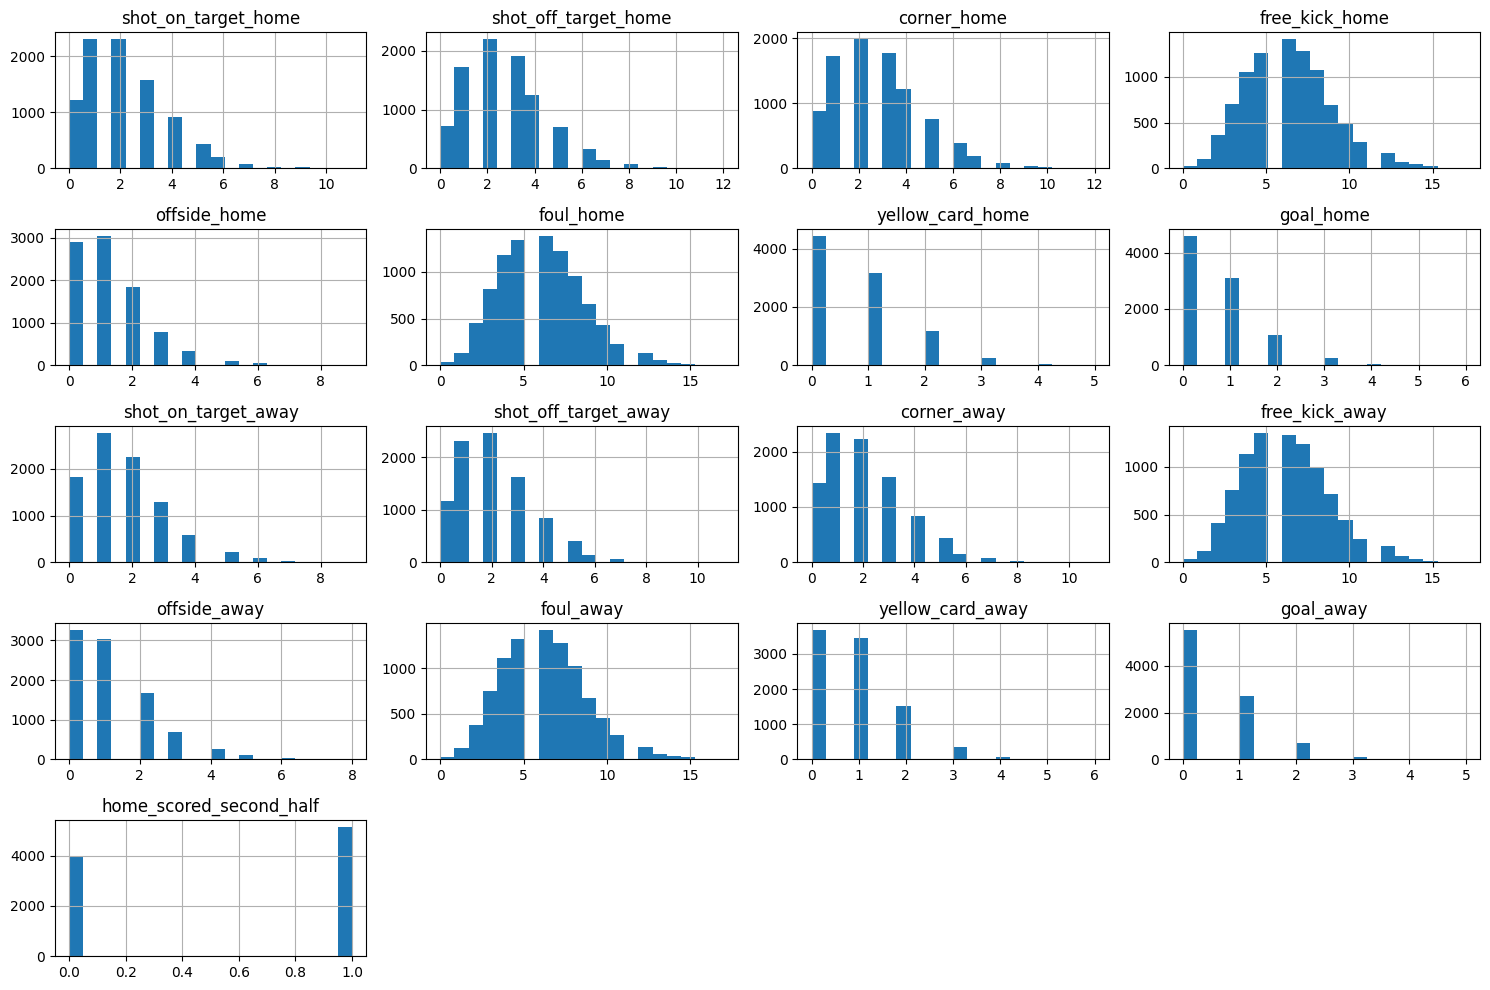

In [7]:
from matplotlib import pyplot as plt

df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()

## Correlation Matrix

<Axes: >

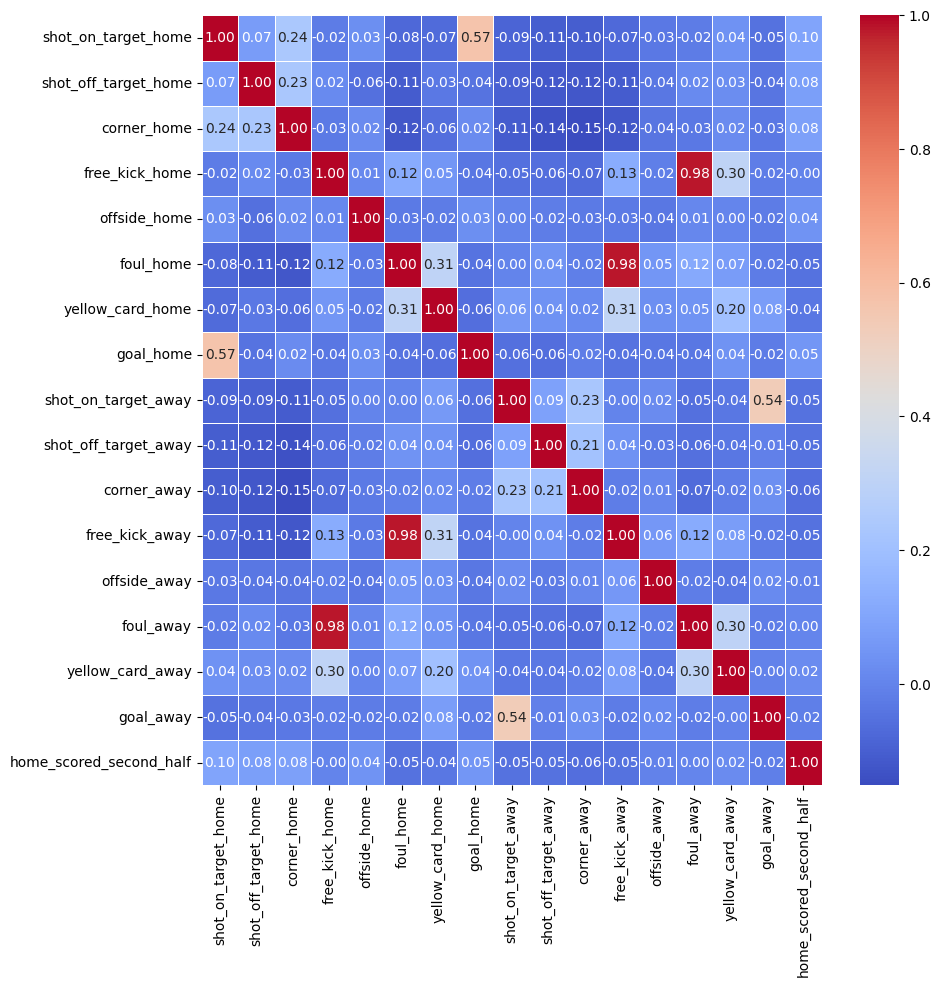

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

correlation_data = df.drop("id_odsp", axis="columns").corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Modeling

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X = df.drop(["home_scored_second_half", "id_odsp"], axis="columns")
y = df["home_scored_second_half"]

seed=42 #Set a random seed
test_size=0.20 # 20% of the dataset is for test, remaining 80% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (7259, 16)
y_train: (7259,)
X_test: (1815, 16)
y_test: (1815,)


Let's test a simple decision tree

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
X, y = df.drop(columns=['id_odsp' ,'home_scored_second_half']), df['home_scored_second_half'] #removing useless columns
seed = 42 #set a random seed

def train_tree(X, y, X_test=None, y_test=None):
    #Define the hyperparameter space
    hyperparameter_space = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    clf = DecisionTreeClassifier(random_state=seed)
    random_search = RandomizedSearchCV( #Randomize search on hyperparameters
        estimator=clf,
        param_distributions=hyperparameter_space,
        n_iter=100,
        cv=5, #k-fold cross validation (k =5)
        scoring='accuracy',
        random_state=seed,
        error_score='raise'
    )
    random_search.fit(X, y)
    best_clf = random_search.best_estimator_ #return the best decision-tree
    print("Best Classifier:", best_clf)
    test_score = None
    if X_test is not None:
        y_pred = best_clf.predict(X_test)
        test_score = accuracy_score(y_test, y_pred)
    return best_clf, float(random_search.best_score_), test_score

best_clf, train_score, test_score = train_tree(X, y)
train_score, test_score

Best Classifier: DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=4,
                       random_state=42)


(0.5675556810968257, None)